In [1]:
class Config:
    database_path = './hmscs.db'
    table_field_widths = [13, 10, 10, 10]


import sqlite3

conn = sqlite3.connect(Config.database_path)

cq = conn.cursor()
cq.execute('''
    select HistoryWaveId, DataLength, SampleFreq, SampleTime
    from T_HistoryWave 
    where HistoryWaveId >= 309
    order by SampleTime desc
    limit 50
    '''
)

result = list(cq.fetchall())
print(len(result))

cols =  'HistoryWaveId DataLength SampleFreq SampleTime'.split()
print('%{}s %{}s %{}s %{}s'.format(*Config.table_field_widths) % tuple(cols))

for row in result:
    # print([type(i) for i in row])
    print('%{}d %{}d %{}.0f %{}s'.format(*Config.table_field_widths) % tuple(row))

32
HistoryWaveId DataLength SampleFreq SampleTime
          351       8192      12800 2020-06-19 17:47:11
          350       8192      12800 2020-06-19 17:46:50
          349       8192      12800 2020-06-19 17:46:31
          348       8192      12800 2020-06-19 17:45:37
          347       8192      12800 2020-06-19 17:44:04
          346       8192      12800 2020-06-19 17:43:42
          345       8192      12800 2020-06-19 17:43:24
          344       8192      12800 2020-06-19 17:43:05
          343       8192      12800 2020-06-19 17:41:13
          342       8192      12800 2020-06-19 17:40:54
          341       8192      12800 2020-06-19 17:40:34
          340       8192      12800 2020-06-19 17:40:15
          339       8192      12800 2020-06-19 17:39:14
          338       8192      12800 2020-06-19 17:38:54
          337       8192      12800 2020-06-19 17:38:37
          336       8192      12800 2020-06-19 17:38:14
          335       8192      12800 2020-06-19 17:32:4

In [2]:


class Sample:
    def __init__(self, gear_id, direction, forced, wave):
        self.gear_id = gear_id
        self.direction = direction
        self.forced = forced
        self.wave = wave
        
    def __repr__(self):
        return f'S({self.gear_id} {self.direction:5s} {"f" if self.forced else " "} len={len(self.wave)})'
        


In [3]:
import sqlite3

conn = sqlite3.connect(Config.database_path)
cq = conn.cursor()
cq.execute('''
    select HistoryWaveId, DataLength, SampleFreq, SampleTime, WaveData
    from T_HistoryWave
    where HistoryWaveId >= 309
    order by SampleTime
    '''
)

samples = []

import bz2 as z
import array
for i, (historywaveid, datalength, samplefreq, sampletime, bdata) in enumerate(cq.fetchall()):
    bdata = z.decompress(bdata)
    farr = array.array('f')
    farr.frombytes(bdata)
    
    init = dict(
        gear_id=i//4 + 1,
        direction=['left', 'right'][i%4//2],
        forced=[False, True][i%2],
        wave=farr
    )
    
#     print(f'{historywaveid:3d} {sampletime} {init}')
    s = Sample(**init)
    samples.append(s)
    
    print(s)

S(1 left    len=8192)
S(1 left  f len=8192)
S(1 right   len=8192)
S(1 right f len=8192)
S(2 left    len=8192)
S(2 left  f len=8192)
S(2 right   len=8192)
S(2 right f len=8192)
S(3 left    len=8192)
S(3 left  f len=8192)
S(3 right   len=8192)
S(3 right f len=8192)
S(4 left    len=8192)
S(4 left  f len=8192)
S(4 right   len=8192)
S(4 right f len=8192)
S(5 left    len=8192)
S(5 left  f len=8192)
S(5 right   len=8192)
S(5 right f len=8192)
S(6 left    len=8192)
S(6 left  f len=8192)
S(6 right   len=8192)
S(6 right f len=8192)
S(7 left    len=8192)
S(7 left  f len=8192)
S(7 right   len=8192)
S(7 right f len=8192)
S(8 left    len=8192)
S(8 left  f len=8192)
S(8 right   len=8192)
S(8 right f len=8192)


In [5]:
import numpy as np
import matplotlib.pyplot as plt

In [6]:
import contextlib

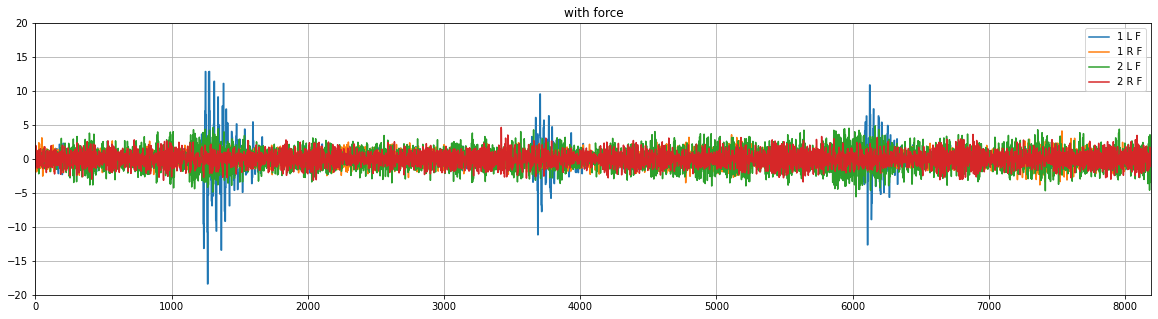

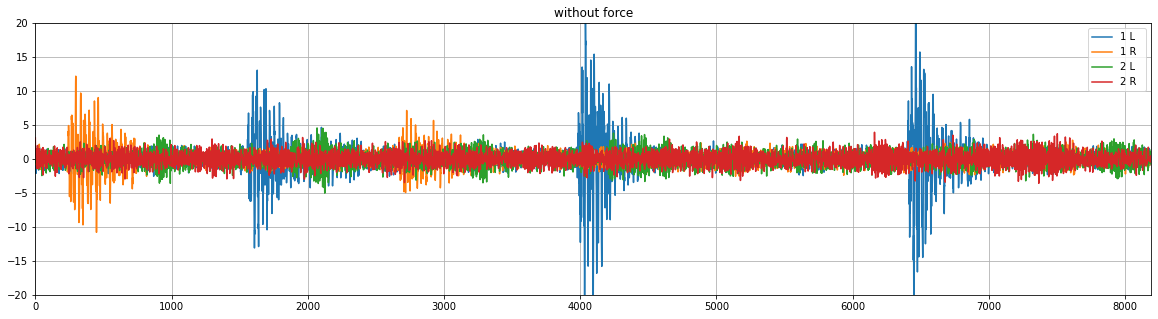

In [7]:

@contextlib.contextmanager
def plot():
    plt.figure(figsize=(20,5))
    yield
    plt.xlim(0, 8192)
    plt.ylim(-20,20)
    plt.grid(True)
    plt.show()
    
def r(s):
    return f'{s.gear_id} {dict(right="R",left="L")[s.direction]} {"F" if s.forced else " "}'

some_samples = samples[:8]

with plot():
    for s in some_samples:
        if s.forced:
            plt.plot(s.wave, label=r(s))
    plt.legend()
    plt.title("with force")
            
with plot():
    for s in some_samples:
        if not s.forced:
            plt.plot(s.wave, label=r(s))
    plt.legend()
    plt.title("without force")



In [8]:
def info_to_index(gear_id, direction, forced):
    return (gear_id-1) * 4 \
        + dict(L=0, R=2)[direction] \
        + {True:1, False:0}[forced]

## Hilbert Enveloping

Tried to use Hilbert transform directly. The result is terrible.

So I tried to apply a low pass filter before enveloping.
The result is better, but the peaks of the waveform are attenuated, which could affect the peak finding step.

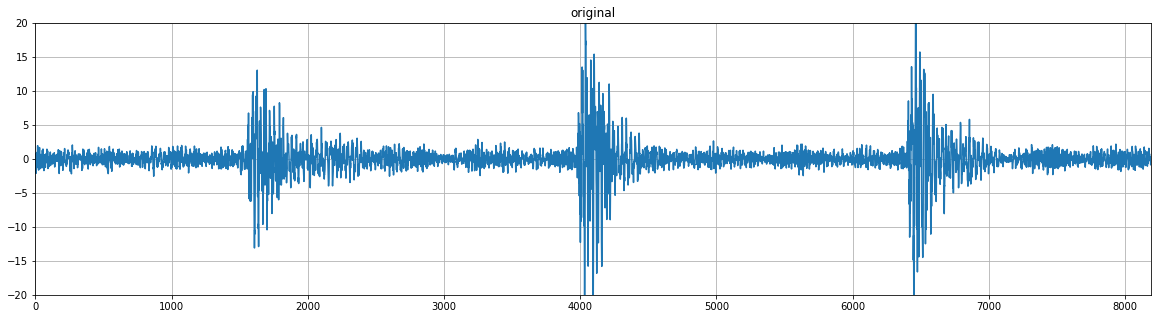

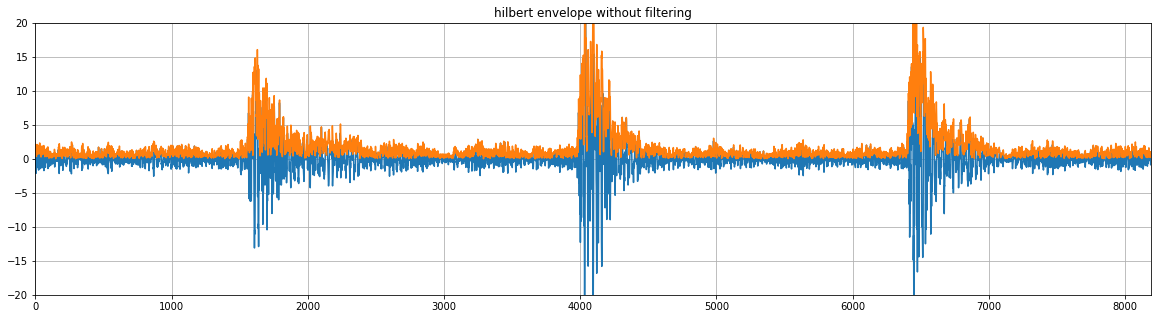

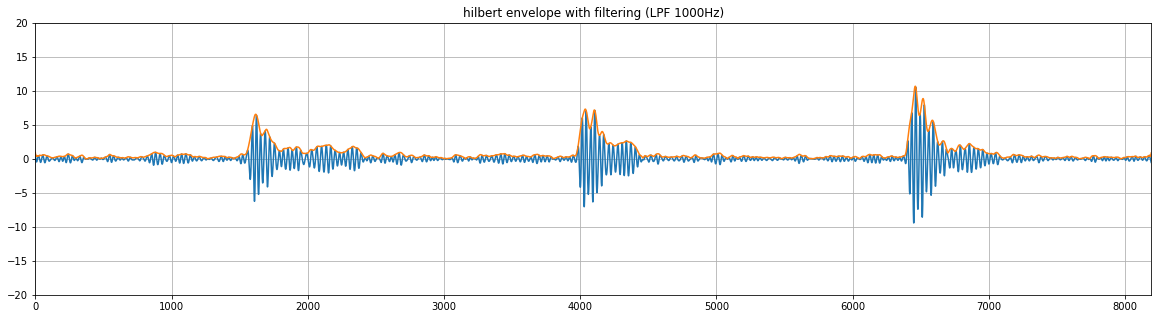

In [10]:
@contextlib.contextmanager
def plot(title):
    plt.figure(figsize=(20,5))
    plt.title(title)
    yield
    plt.xlim(0, 8192)
    plt.ylim(-20,20)
    plt.grid(True)
    plt.show()
    
from scipy.signal import hilbert, butter, filtfilt


w = samples[info_to_index(1, 'L', False)]
signal = w.wave
with plot(title='original'):
    plt.plot(signal)

analytic_signal = hilbert(signal)
amplitude_envelope = np.abs(analytic_signal)

with plot(title='hilbert envelope without filtering'):
    plt.plot(signal)
    plt.plot(amplitude_envelope)
    
cut_off_freq = 1000/12.8e3
b, a1 = butter(4, cut_off_freq, btype='lowpass')
signal = filtfilt(b, a1, signal)

analytic_signal = hilbert(signal)
amplitude_envelope = np.abs(analytic_signal)

with plot(title='hilbert envelope with filtering (LPF 1000Hz)'):
    plt.plot(signal)
    plt.plot(amplitude_envelope)


## Empirical Envelope Estimation Algorithm (EEEA)

In [ ]:
def eeea(wave):
    n_peak = 5
    n_loop = 20
    fs = 12800
    ts = 0.01
    tsl = 0.25 * ts
    duration = len(wave) / fs

    
    def ism(w, wi):
        wio = [0]
        for ii in range(1, len(wi)-1): # ii-1 ii ii+1
            cond = w[wi[ii-1]] < w[wi[ii]] >= w[wi[ii+1]]
            if cond:
                wio.append(wi[ii])
        if wio[-1] != len(w)-1:
            wio.append(len(w)-1)
        return wio
    
    def lpp(wi, lwi):
        tsl_n = int(tsl*fs)
        ts_n = int(ts*fs)
#         print(f'tsl_n = {tsl_n}; ts_n = {ts_n}')
        
        ii = 0
        while ii < len(wi)-1:
            if wi[ii+1]-wi[ii] > ts_n:
                wi.insert(ii+1, wi[ii]+tsl_n) # notice the ii+1, it takes a long time to debug
            ii += 1
    
            
    wave_i = range(len(wave))
    for i in range(n_loop):
        old_wave_i = wave_i
        wave_i = ism(wave, wave_i)
        if len(wave_i) < n_peak:
            break
        lpp(wave_i, old_wave_i)
#         print(len(old_wave_i), len(wave_i))
#         plt.plot(wave_i, [wave[i] for i in wave_i], label=f'{i}')
    
    plt.scatter(wave_i, [wave[i] for i in wave_i], s=100)
        
    return wave_i
    
@contextlib.contextmanager
def plot(title):
    plt.figure(figsize=(20,5))
    plt.title(title)
    yield
#     plt.xlim(0, 8192)
    y_range = 35
    plt.ylim(-y_range,y_range)
    plt.grid(True)
    plt.show()

w = samples[info_to_index(1, 'L', False)]
signal = w.wave
with plot(title='EEEA enveloping'):
    plt.plot(signal, color='gray')
    envelope = eeea(signal)
#     plt.plot(eeea(signal))

the cell above is the original EEEA algorithm with a mistakes corrected:

> Here the local maxima mean the point whose value is greater than
> its proceeding one but less than or equal to the next one.

This sentence should be expressed in a wrong way, and it should means 
`proceeding one < local minima >= next one`

### EEEA with `bisect` last iteration maxima selection

As shown in the last plot:

The seeming minimas are also presenting in the enveloping result, which cannot be beared.

It should be the side effect of `Local Peaks Precessing` step. 

> Between the two maxima, if `dtemp` is greater than `ts`, the **non-maxima**
> points whose time interval to its proceeding point is greater than `tsl` 
> **will be added to the ID**.

the minimas present in the envelop should be the `added non-maxima`

So, in this section, I'm trying to use the `real local maxima` from the last
iteration to fill up the `dtemp` gap.

In [ ]:
from scipy.interpolate import interp1d

def around(arr, i, l, r):
    ll = max(i-l, 0)
    rr = min(i+r, len(arr))
    
    for ii in range(ll, rr):
        if ii != i:
            print(arr[ii], end=', ')
        else:
            print(f'<{arr[ii]}>', end=', ')
    print()

def eeea(wave):
    n_peak = 5
    n_loop = 20
    fs = 12800
    ts = 0.01
    tsl = 0.25 * ts
    duration = len(wave) / fs
    
    tsl_n = int(tsl*fs)
    ts_n = int(ts*fs)
#     print(f'tsl_n = {tsl_n}; ts_n = {ts_n}')
    
    def iterative_search_of_maxima(wi):
        wio = [0]
        for ii in range(1, len(wi)-1):
            cond = wave[wi[ii-1]] < wave[wi[ii]] >= wave[wi[ii+1]]
            if cond:
                wio.append(wi[ii])
        if wio[-1] != len(wave)-1:
            wio.append(len(wave)-1)
        return wio

    def local_peaks_processing(new, old):
        ni = 0
        oi = 0
        while ni < len(new)-1:
            if new[ni+1]-new[ni] > ts_n:
                target_index = (new[ni] + new[ni+1])//2
                while True:
                    if old[oi] <= target_index < old[oi+1]:
                        break
                    oi += 1
                if old[oi] == new[ni]:
                    oi += 1
                new.insert(ni+1, old[oi]) # notice the ni+1, it took a long time to debug
            ni += 1
            
    selected_indexes = range(len(wave))
    for i in range(n_loop):
        old_selected_indexes = selected_indexes
        selected_indexes = iterative_search_of_maxima(selected_indexes)
        if len(selected_indexes) < n_peak:
            break
        local_peaks_processing(selected_indexes, old_selected_indexes)
        
        if i not in [0] and i%3==0:
            plt.scatter(selected_indexes, [wave[ii] for ii in selected_indexes], s=100, label=f'{i}')
        
    plt.legend()

    
    plt.scatter(selected_indexes, [wave[i] for i in selected_indexes], s=100, color='orange')
    
    wave_selected = [wave[i] for i in selected_indexes]
    f = interp1d(selected_indexes, wave_selected, 'cubic')
    envelope = f(np.arange(len(wave)))
        
    return envelope
    
@contextlib.contextmanager
def plot(title):
    plt.figure(figsize=(20,5))
    plt.title(title)
    yield
#     plt.xlim(0, 8192)
    y_range = 35
    plt.ylim(-y_range,y_range)
    plt.grid(True)
    plt.show()

w = samples[info_to_index(1, 'L', False)]
signal = w.wave
with plot(title='EEEA enveloping'):
    plt.plot(signal, color='gray')
    envelope = eeea(signal)
    plt.plot(envelope)

In [ ]:
# trying =================================
%matplotlib inline 
from scipy.interpolate import interp1d

def around(prompt, arr, i, l, r):
    ll = max(i-l, 0)
    rr = min(i+r, len(arr))
    print(prompt, end=' ')
    for ii in range(ll, rr):
        if ii != i:
            print(arr[ii], end=', ')
        else:
            print(f'<{arr[ii]}>', end=', ')
    print()

def eeea(wave):
    n_peak = 5
    n_loop = 20
    fs = 12800
    ts = 0.005
    duration = len(wave) / fs
    
    ts_n = int(ts*fs)
#     print(f'tsl_n = {tsl_n}; ts_n = {ts_n}')
    
    def iterative_search_of_maxima(wi):
        wio = [0]
        for ii in range(1, len(wi)-1):
            cond = wave[wi[ii-1]] < wave[wi[ii]] >= wave[wi[ii+1]]
            if cond:
                wio.append(wi[ii])
        if wio[-1] != len(wave)-1:
            wio.append(len(wave)-1)
        return wio

    i=0
    def local_peaks_processing(new, old):
        ni = 0
        oi = 0
        while ni < len(new)-1:
            oim = oi # oi lamdmark
            if new[ni+1]-new[ni] > ts_n:
                target_index = (new[ni] + new[ni+1])//2
                while True:
                    if old[oim] <= target_index < old[oim+1]:
                        break
                    oim += 1
                if old[oim] == new[ni]:
                    oim += 1
                    
                new.insert(ni+1, old[oim]) # notice the ni+1, it took a long time to debug
            else:
                ni += 1
                oi = oim
            
    selected_indexes = range(len(wave))
    while True:
        if i == n_loop:
            break
        else:
            i += 1
#     for i in range(n_loop):
        old_selected_indexes = selected_indexes
        selected_indexes = iterative_search_of_maxima(selected_indexes)
        if len(selected_indexes) < n_peak:
            break
        local_peaks_processing(selected_indexes, old_selected_indexes)
        
#         if i not in [0] and i%3==0:
#             plt.scatter(selected_indexes, [wave[ii] for ii in selected_indexes], s=100, label=f'{i}')
        
#     plt.legend()

    
#     plt.scatter(selected_indexes, [wave[i] for i in selected_indexes], s=100, color='orange')
    
    wave_selected = [wave[i] for i in selected_indexes]
    f = interp1d(selected_indexes, wave_selected, 'cubic')
    envelope = f(np.arange(len(wave)))
        
    return envelope
    
@contextlib.contextmanager
def plot(title):
    plt.figure(figsize=(20,5))
    plt.title(title)
    yield
#     plt.xlim(0, 8192)
    y_range = 35
    plt.ylim(-y_range,y_range)
    plt.grid(True)
    plt.show()

w = samples[info_to_index(1, 'L', False)]
signal = w.wave
with plot(title='EEEA enveloping'):
    plt.plot(signal, color='gray')
    envelope = eeea(signal)
    plt.plot(envelope)

### EEEA without `local peaks processing`

In [ ]:
def around(arr, i, l, r):
    ll = max(i-l, 0)
    rr = min(i+r, len(arr))
    
    for ii in range(ll, rr):
        if ii != i:
            print(arr[ii], end=', ')
        else:
            print(f'<{arr[ii]}>', end=', ')
    print()
    
from scipy.interpolate import interp1d

def eeea(wave):
    n_peak = 5
    n_loop = 3
    fs = 12800
    ts = 0.01
    tsl = 0.25 * ts
    duration = len(wave) / fs


    
    def ism(w, wi):
        wio = [0]
        for ii in range(1, len(wi)-1): # ii-1 ii ii+1
            cond = w[wi[ii-1]] < w[wi[ii]] >= w[wi[ii+1]]
#             print(ii, wi[ii], cond)
            if cond:
                wio.append(wi[ii])
        if wio[-1] != len(w)-1:
            wio.append(len(w)-1)
        return wio
    
            
    wave_i = range(len(wave))
    for i in range(n_loop):
        old_wave_i = wave_i
        wave_i = ism(wave, wave_i)
        if len(wave_i) < n_peak:
            break
        print(len(wave_i))
        
#         plt.plot(wave_i, [wave[i] for i in wave_i], label=f'{i}')
    
#     plt.scatter(wave_i, [wave[i] for i in wave_i], s=100, label=f'{i}')

#     plt.legend()
    
    wave_selected = [wave[i] for i in wave_i]
    f = interp1d(wave_i, wave_selected, 'cubic')
    envelope = f(np.arange(len(wave)))
    plt.plot(envelope)
        
    return envelope
    
@contextlib.contextmanager
def plot(title):
    plt.figure(figsize=(20,5))
    plt.title(title)
    yield
#     plt.xlim(0, 8192)
    y_range = 35
    plt.ylim(-y_range,y_range)
    plt.grid(True)
    plt.show()

w = samples[info_to_index(1, 'L', False)]
signal = w.wave
with plot(title='EEEA enveloping without LPP'):
    plt.plot(signal, color='gray')
    envelope = eeea(signal)
#     plt.plot(eeea(signal))

### EEEA with `n samples shift` last iteration maxima selection

NOT WORK PROPERLY

In [ ]:
def around(arr, i, l, r):
    ll = max(i-l, 0)
    rr = min(i+r, len(arr))
    
    for ii in range(ll, rr):
        if ii != i:
            print(arr[ii], end=', ')
        else:
            print(f'<{arr[ii]}>', end=', ')
    print()

def eeea(wave):
    n_peak = 5
    n_loop = 20
    fs = 12800
    ts = 0.01
    tsl = 0.25 * ts
    duration = len(wave) / fs


    
    def ism(w, wi):
        wio = [0]
        for ii in range(1, len(wi)-1): # ii-1 ii ii+1
            cond = w[wi[ii-1]] < w[wi[ii]] >= w[wi[ii+1]]
#             print(ii, wi[ii], cond)
            if cond:
                wio.append(wi[ii])
        if wio[-1] != len(w)-1:
            wio.append(len(w)-1)
        return wio
    
#     def lpp(wi, lwi):
#         ii = 0
#         while ii < len(wi)-1:
#             if wi[ii+1]-wi[ii] > ts_n:
# #                 print(f'{wi[ii+1]}-{wi[ii]}= {wi[ii+1]-wi[ii]} > {ts_n}')
# #                 print(wi[ii-5:ii+2])
# #                 print(f'insert [{ii}]={wi[ii]} {wi[ii]+tsl_n}')
#                 wi.insert(ii+1, wi[ii]+tsl_n) # notice the ii+1, it takes a long time to debug
#             ii += 1
# #             if ii > 100:
# #                 break

    def lpp(new, old):
        tsl_n = int(tsl*fs)
        ts_n = int(ts*fs)
        print(f'tsl_n = {tsl_n}; ts_n = {ts_n}')
        
        ni = 0
        oi = 0
        while ni < len(new)-1:
            if new[ni+1]-new[ni] > ts_n:
                
                # find the max `oi` s.t. old[oi] < new[ni] + tsl_n
                while True:
                    if old[oi+1] < new[ni]+tsl_n:
                        print(f'{old[oi+1]} < {new[ni]+tsl_n}')
                        oi += 1
                        around(old, oi, 5, 5)
                    else:
                        break
                        
                print(f'{new[ni+1]}-{new[ni]}= {new[ni+1]-new[ni]} > {ts_n}')
                print('new: ', end=''); around(new, ni, 5, 5)
                print('old: ', end=''); around(old, oi, 5, 5)

                print(f'insert [{ni}]={new[ni]} {old[oi]}')
                new.insert(ni+1, old[oi]) # notice the ni+1, it took a long time to debug
            ni += 1
            if ni > 10:
                break
    
            
    wave_i = range(len(wave))
    for i in range(n_loop):
        old_wave_i = wave_i
        wave_i = ism(wave, wave_i)
        if len(wave_i) < n_peak:
            break
        print(len(wave_i))
        lpp(wave_i, old_wave_i)
        print(len(wave_i))
        print('='*20)
        
#         plt.plot(wave_i, [wave[i] for i in wave_i], label=f'{i}')
    
    plt.scatter(wave_i, [wave[i] for i in wave_i], s=100, label=f'{i}')


    plt.legend()
        
    return wave_i
    
@contextlib.contextmanager
def plot(title):
    plt.figure(figsize=(20,5))
    plt.title(title)
    yield
#     plt.xlim(0, 8192)
    y_range = 35
    plt.ylim(-y_range,y_range)
    plt.grid(True)
    plt.show()

w = samples[info_to_index(1, 'L', False)]
signal = w.wave
with plot(title='EEEA enveloping'):
    plt.plot(signal, color='gray')
    envelope = eeea(signal)
#     plt.plot(eeea(signal))

In [ ]:
samples = np.load('samples.npz')
def r(i):
    gear_id=i//4 + 1
    direction=['L', 'R'][i%4//2]
    forced=['-', 'F'][i%2]
    return f'{gear_id}{direction}{forced}'
signal = samples[r(25)]

In [ ]:
from scipy.interpolate import interp1d
from typing import List


def eeea(wave: List[float], 
        fs: float = 12800, ts: float = 0.005, n_peak: int = 5, n_loop: int = 20
    ) -> List[float]:
    """the Empirical Envelope Estimation Algorithm.

    The [wave] will be enveloped with smoothness defined by [ts]. The shorter 
    the [ts], the more fine-grained the envelope; the longer the [ts], the 
    smoother the envelope (though details might be lost). [fs] is the sampling 
    frequency. At least [n_peaks] points will be selected from the [wave] to 
    form the envelope. And the algorithm will iterate [n_loop] times before 
    ending. You can keep [n_loop] unchanged for most of the cases, the result 
    is not sensitive to it.
    """
    def iterative_search_of_maxima(wi):
        wio = [0]
        for ii in range(1, len(wi)-1):
            cond = wave[wi[ii-1]] < wave[wi[ii]] >= wave[wi[ii+1]]
            if cond:
                wio.append(wi[ii])
        if wio[-1] != len(wave)-1:
            wio.append(len(wave)-1)
        return wio

    ts_n = int(ts*fs)

    def local_peaks_processing(new, old):
        ni = 0
        oi = 0
        while ni < len(new)-1:
            oim = oi  # oi lamdmark
            if new[ni+1]-new[ni] > ts_n:
                target_index = (new[ni] + new[ni+1])//2
                while True:
                    if old[oim] <= target_index < old[oim+1]:
                        break
                    oim += 1
                if old[oim] == new[ni]:
                    oim += 1

                # notice the ni+1, it took a long time to debug
                new.insert(ni+1, old[oim])
            else:
                ni += 1
                oi = oim

    selected_indexes = range(len(wave))
    for i in range(n_loop):
        old_selected_indexes = selected_indexes
        selected_indexes = iterative_search_of_maxima(selected_indexes)
        if len(selected_indexes) < n_peak:
            break
        local_peaks_processing(selected_indexes, old_selected_indexes)

    wave_selected = [wave[i] for i in selected_indexes]
    wave_selected[0] = wave_selected[1]
    wave_selected[-1] = wave_selected[-2]
    f = interp1d(selected_indexes, wave_selected, 'cubic')
    envelope = f(range(len(wave)))

    return envelope

@contextlib.contextmanager
def plot(title):
    plt.figure(figsize=(20,5))
    plt.title(title)
    yield
#     plt.xlim(0, 8192)
    y_range = 35
    plt.ylim(-y_range,y_range)
    plt.grid(True)
    plt.show()


with plot(title='EEEA enveloping'):
    plt.plot(signal, color='gray')
    envelope = eeea(signal)
    plt.plot(envelope)